In [1]:
import numpy as np
import pandas as pd

In [2]:
filename = 'data/counts.txt'

In [3]:
with open(filename, 'rt') as f:
    data_table = pd.read_csv(f, index_col=0)

In [4]:
print(data_table.iloc[:5, :5])

       00624286-41dd-476f-a63b-d2a5f484bb45  TCGA-FS-A1Z0  TCGA-D9-A3Z1  \
A1BG                                1272.36        452.96        288.06   
A1CF                                   0.00          0.00          0.00   
A2BP1                                  0.00          0.00          0.00   
A2LD1                                164.38        552.43        201.83   
A2ML1                                 27.00          0.00          0.00   

       02c76d24-f1d2-4029-95b4-8be3bda8fdbe  TCGA-EB-A51B  
A1BG                                 400.11        420.46  
A1CF                                   1.00          0.00  
A2BP1                                  0.00          1.00  
A2LD1                                165.12         95.75  
A2ML1                                  0.00          8.00  


In [5]:
samples = list(data_table.columns)

In [6]:
filename = 'data/genes.csv'

In [7]:
with open(filename, 'rt') as f:
    gene_info = pd.read_csv(f, index_col=0)

In [8]:
print(gene_info.iloc[:5, :])

            GeneID  GeneLength
GeneSymbol                    
CPA1          1357        1724
GUCY2D        3000        3623
UBC           7316        2687
C11orf95     65998        5581
ANKMY2       57037        2611


In [9]:
matched_index = pd.Index.intersection(data_table.index, gene_info.index)

In [10]:
counts = np.asarray(data_table.loc[matched_index], dtype=int)

In [11]:
gene_names = np.array(matched_index)

In [15]:
print('{} genes measured in {} individuals'.format(counts.shape[0], counts.shape[1]))

20500 genes measured in 375 individuals


In [16]:
gene_lengths = np.asarray(gene_info.loc[matched_index]['GeneLength'], dtype=int)

In [17]:
print(counts.shape)
print(gene_lengths.shape)

(20500, 375)
(20500,)


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('style/elegant.mplstyle')

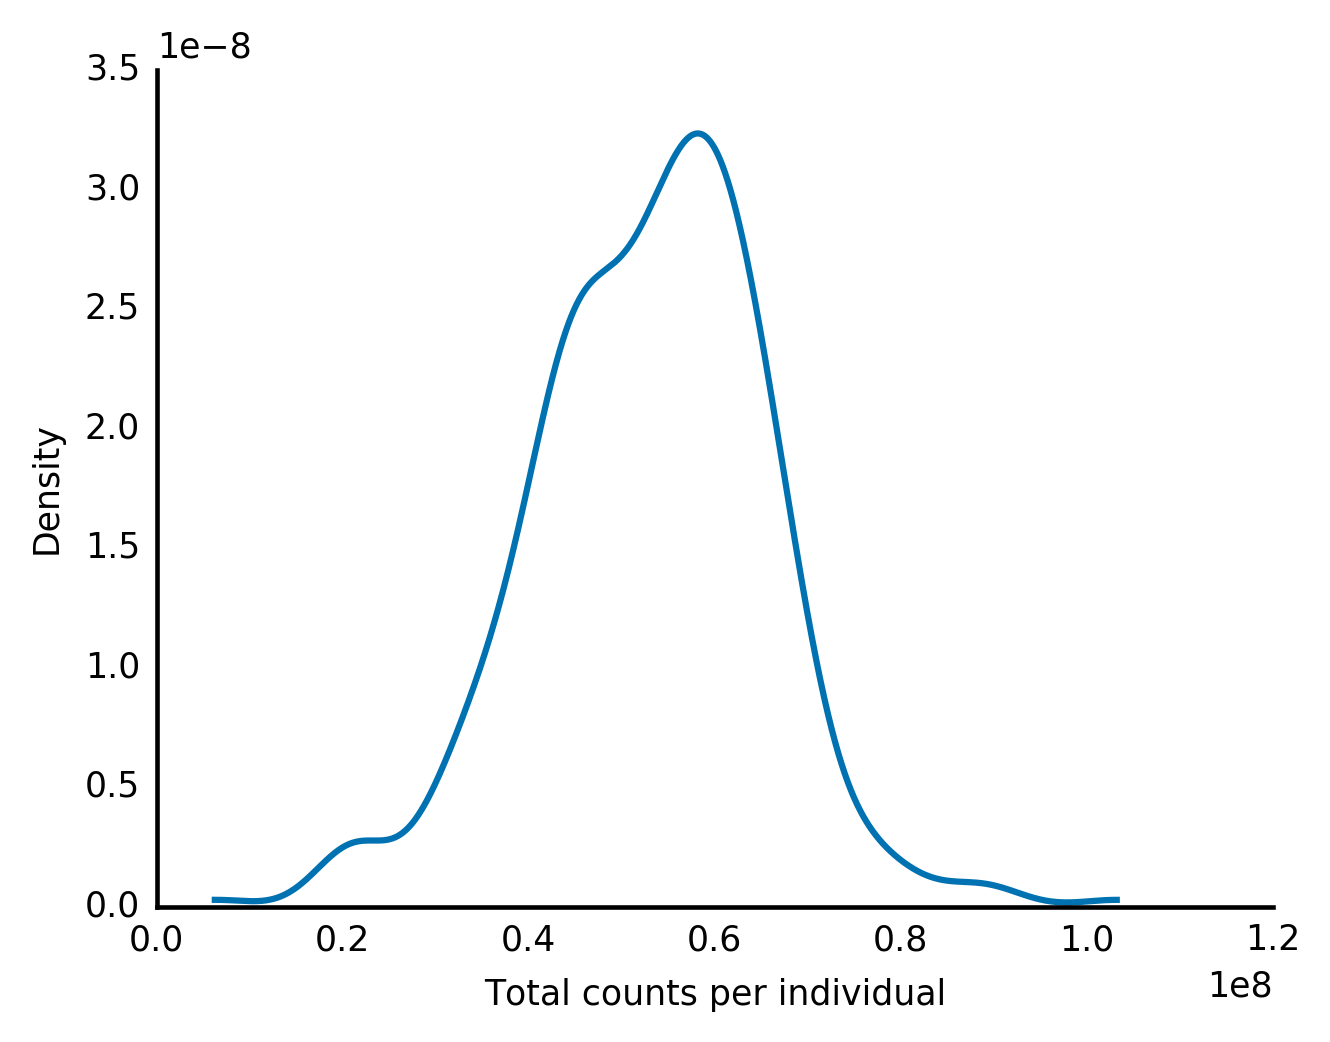

In [26]:
total_counts = np.sum(counts, axis=0)
from scipy import stats

density = stats.kde.gaussian_kde(total_counts)
x = np.arange(min(total_counts), max(total_counts), 10000)

fig, ax = plt.subplots()
ax.plot(x, density(x))
ax.set_xlabel("Total counts per individual")
ax.set_ylabel("Density")

plt.show()

In [21]:
print("Count statistics: \n min: {} \n mean: {} \n max: {}".format(np.min(total_counts), np.mean(total_counts), np.max(total_counts)))

Count statistics: 
 min: 6231205 
 mean: 52995255.33866667 
 max: 103219262


order of mag difference between highest and lowest; different numbers of RNAseq. 
They have "different library sizes" 
The library sizes need to be normalized. 

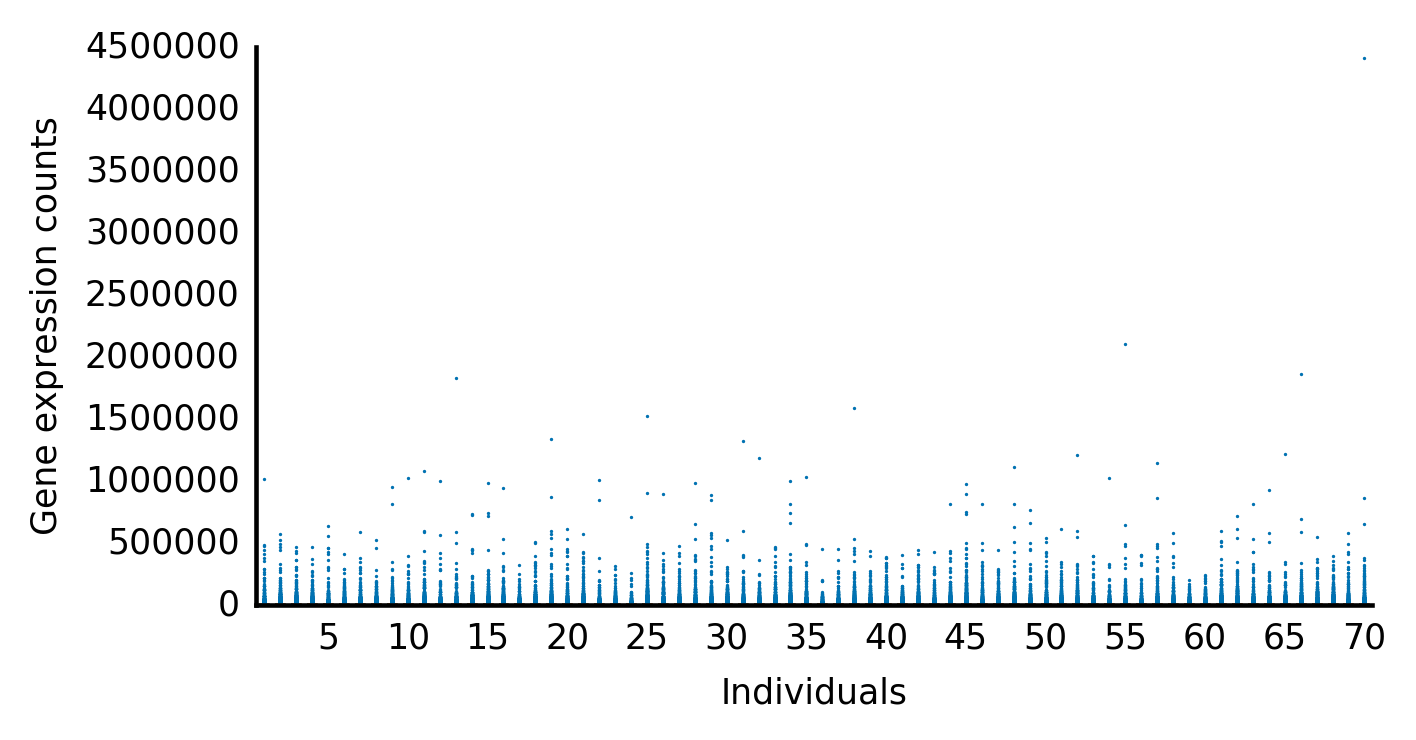

In [23]:
# Subset of data for plotting
np.random.seed(seed=7)
# Randomly select 70 samples
samples_index = np.random.choice(range(counts.shape[1]), size=70, replace=False)
counts_subset = counts[:, samples_index]
# Some custom x-axis labelling to make our plots easier to read
def reduce_xaxis_labels(ax, factor):
    plt.setp(ax.xaxis.get_ticklabels(), visible=False)
    for label in ax.xaxis.get_ticklabels()[factor-1::factor]:
        label.set_visible(True)
        
fig, ax = plt.subplots(figsize=(4.8, 2.4))

with plt.style.context('style/thinner.mplstyle'):
    ax.boxplot(counts_subset)
    ax.set_xlabel("Individuals")
    ax.set_ylabel("Gene expression counts")
    reduce_xaxis_labels(ax, 5)

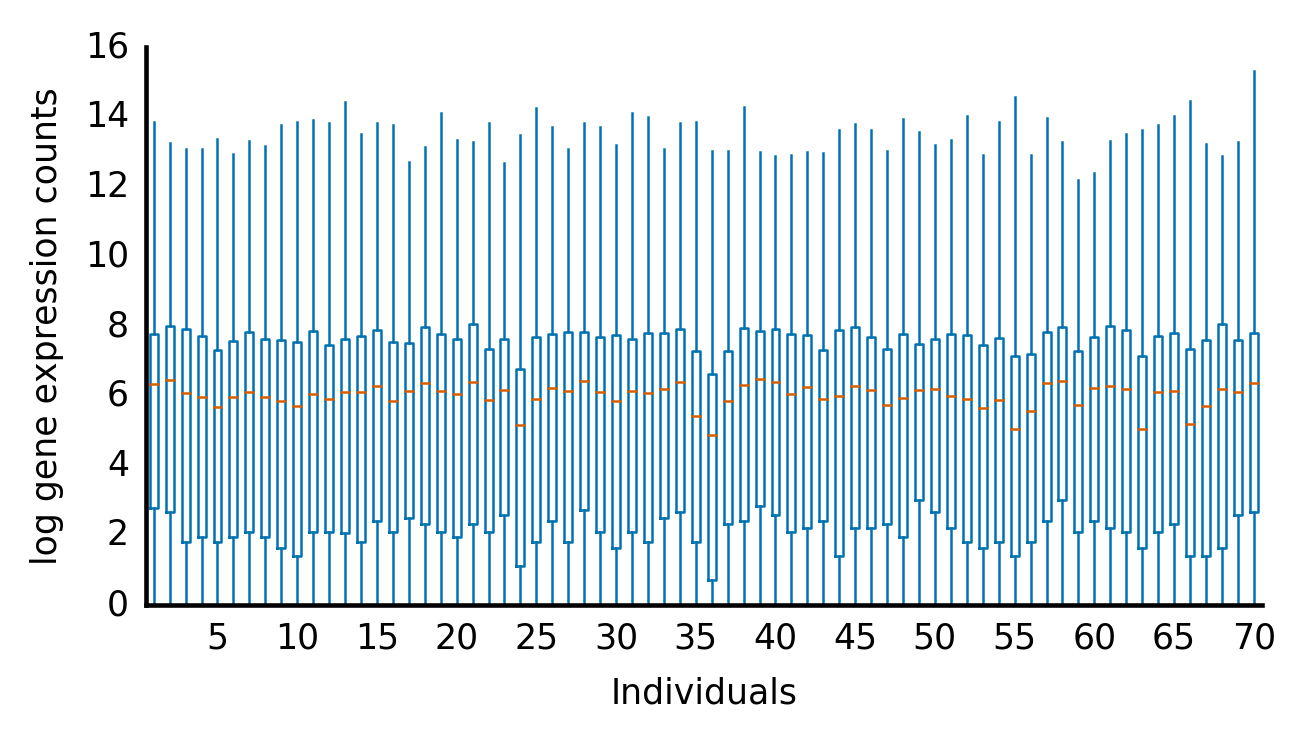

In [24]:
# Seem to be a lot of outliers at end of scale.
# Do log(n+1) of data

fig, ax = plt.subplots(figsize=(4.8, 2.4))

with plt.style.context('style/thinner.mplstyle'):
    ax.boxplot(np.log(counts_subset + 1))
    ax.set_xlabel("Individuals")
    ax.set_ylabel("log gene expression counts")
    reduce_xaxis_labels(ax, 5)

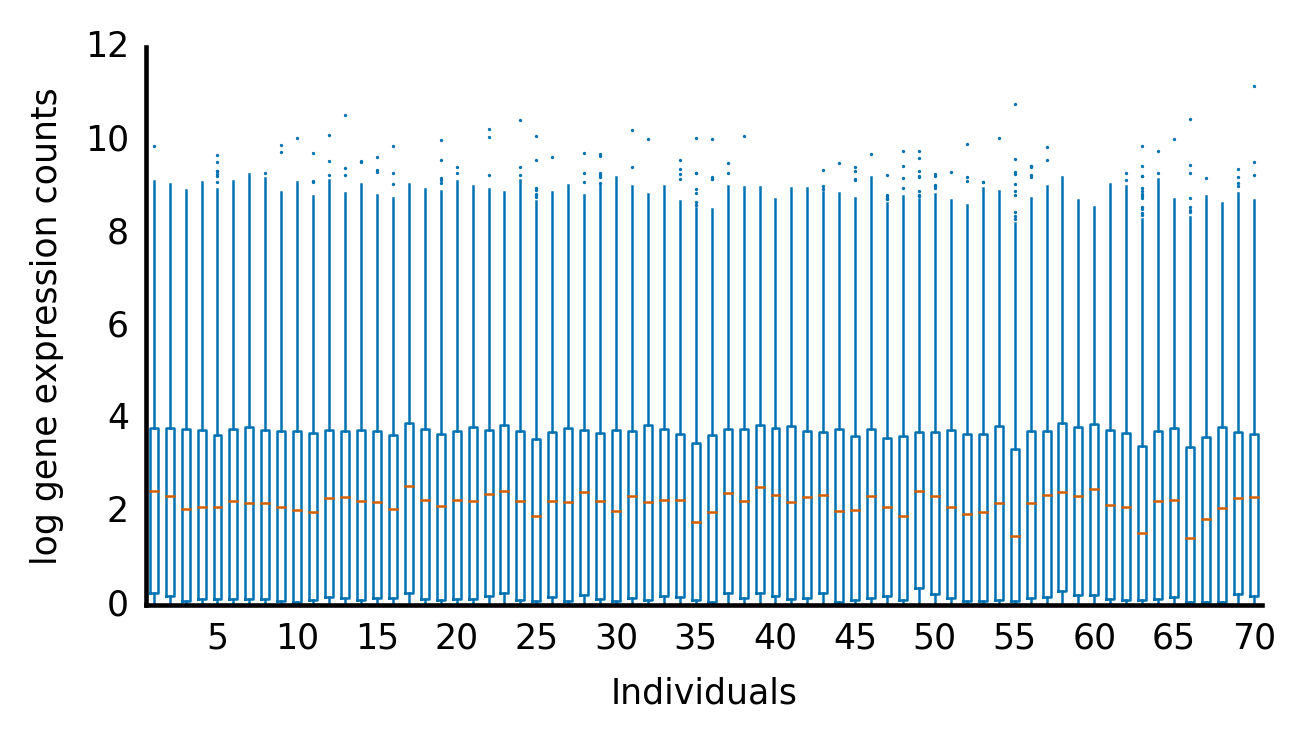

In [29]:
# Normalize by library size
# Divide the expression counts by the total counts for that individual
# Multiply by 1 million to get things back in similar scale

counts_lib_norm = counts / total_counts * 1000000

counts_subset_lib_norm = counts_lib_norm[:, samples_index]

fig, ax = plt.subplots(figsize=(4.8, 2.4))

with plt.style.context('style/thinner.mplstyle'):

    ax.boxplot(np.log(counts_subset_lib_norm + 1))
    ax.set_xlabel("Individuals")
    ax.set_ylabel("log gene expression counts")
    reduce_xaxis_labels(ax, 5)

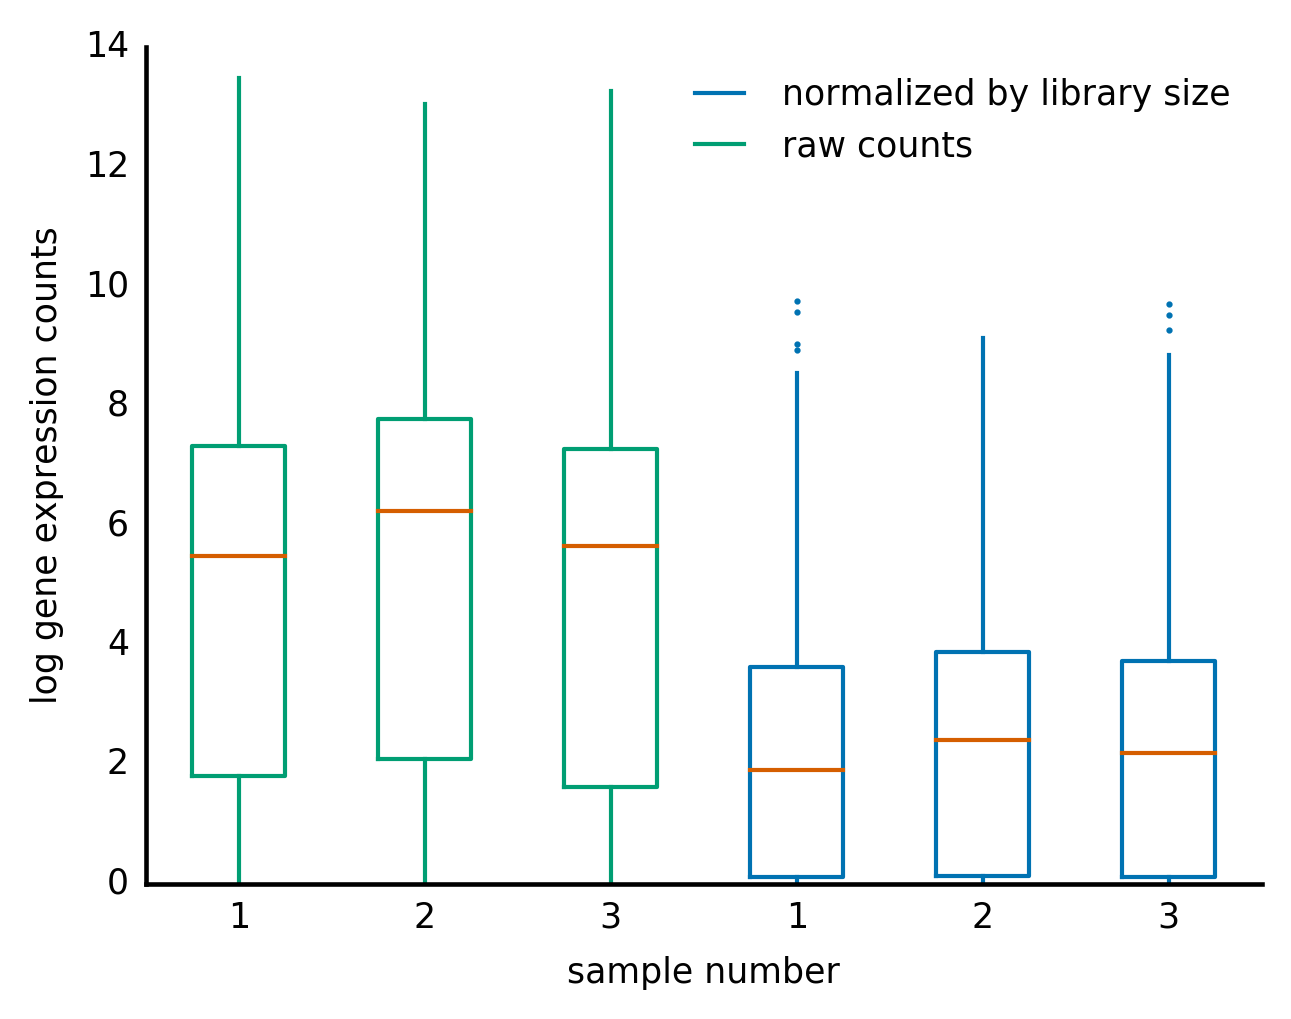

In [31]:
# Compare normalized data to raw data
import itertools as it
from collections import defaultdict

def class_boxplot(data, classes, colors=None, **kwargs):
    all_classes = sorted(set(classes))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    class2color = dict(zip(all_classes, it.cycle(colors)))
    
    # map classes to data vectors
    class2data = defaultdict(list)
    for distrib, cls in zip(data, classes):
        for c in all_classes:
            class2data[c].append([])
        class2data[cls][-1] = distrib
        
    # do each boxplot with appropriate color
    fig, ax = plt.subplots()
    lines = []
    for cls in all_classes:
        for key in ['boxprops', 'whiskerprops', 'flierprops']:
            kwargs.setdefault(key, {}).update(color=class2color[cls])
        # draw the boxplot
        box = ax.boxplot(class2data[cls], **kwargs)
        lines.append(box['whiskers'][0])
    ax.legend(lines, all_classes)
    return ax

log_counts_3 = list(np.log(counts.T[:3]+1))
log_ncounts_3 = list(np.log(counts_lib_norm.T[:3]+1))
ax = class_boxplot(log_counts_3 + log_ncounts_3, ['raw counts']*3 + ['normalized by library size']*3, labels=[1,2,3,1,2,3])
ax.set_xlabel('sample number')
ax.set_ylabel('log gene expression counts')

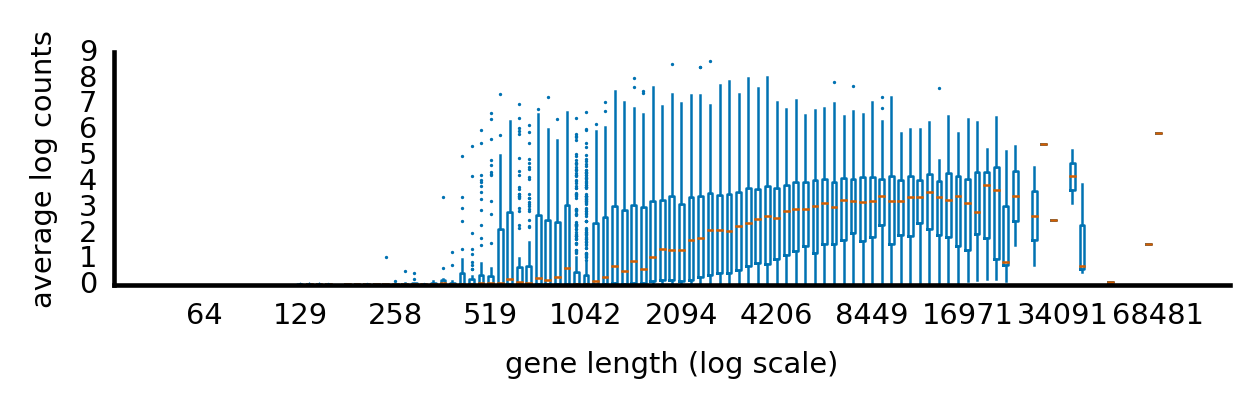

In [32]:
# Check the relationship between gene length and counts

def binned_boxplot(x, y, *, xlabel='gene length (log scale)', ylabel='average log counts'):
    x_hist, x_bins = np.histogram(x, bins='auto')
    # digitize numbers the bins
    x_bin_idxs = np.digitize(x, x_bins[:-1])
    binned_y = [y[x_bin_idxs == i] for i in range(np.max(x_bin_idxs))]
    fig, ax = plt.subplots(figsize=(4.8, 1))
    
    x_bin_centers = (x_bins[1:] + x_bins[:-1]) / 2
    x_ticklabels = np.round(np.exp(x_bin_centers)).astype(int)
    
    ax.boxplot(binned_y, labels=x_ticklabels)
    
    reduce_xaxis_labels(ax, 10)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
log_counts = np.log(counts_lib_norm + 1)
mean_log_counts = np.mean(log_counts, axis=1)
log_gene_lengths = np.log(gene_lengths)
    
with plt.style.context('style/thinner.mplstyle'):
    binned_boxplot(x=log_gene_lengths, y=mean_log_counts)

In [33]:
# Looks like the longer a gene is the higher the measured counts. This is a technical artifact.
# Need to normalize by RPKM technique

C = counts
N = counts.sum(axis=0)
L = gene_lengths

C_tmp = 10^9 * C


In [35]:
print(C_tmp.shape)
print(L.shape)

(20500, 375)
(20500,)


In [36]:
# Adjust L's dimensions so can be broadcast with C_tmp

L = L[:, np.newaxis]
print(C_tmp.shape)
print(L.shape)

(20500, 375)
(20500, 1)


In [37]:
C_tmp = C_tmp / L

In [38]:
# Finally normalize by library size
N = counts.sum(axis=0)

print(N.shape)

(375,)


In [40]:
# Dimensions do match, but append extra dimension anyway for readability
N = N[np.newaxis, :]
print(C_tmp.shape)
print(L.shape)

(20500, 375)
(20500, 1)


In [41]:
# Divide each column by the total counts for that column (N)
rpkm_counts = C_tmp/N

In [42]:
# Put into function
def rpkm(counts, lengths):
    L = np.sum(counts, axis=0)
    L = lengths
    C = counts
    
    normed = 1e9 * C / (N[np.newaxis, :] * L[:, np.newaxis])
    return(normed)

counts_rpkm = rpkm(counts, gene_lengths)

In [43]:
# Plot the RPKM-normalized values

log_counts = np.log(counts_rpkm + 1)
mean_log_counts = np.mean(log_counts, axis=1)
log_gene_lengths = np.log(gene_lengths)

with plt.style.context('style/thinner.mplstyle'):
    binned_boxplot(x=log_gene_lengths, y=mean_log_counts)

/Users/cgosmeyer/anaconda2/envs/astroconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 20500


IndexError: index 7636 is out of bounds for axis 0 with size 1